In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import keras
import matplotlib.pyplot as plt 
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras import Model, Sequential, layers
from keras.layers import Dense, Input, BatchNormalization
from keras.saving.save import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
z = ZipFile('drive/My Drive/My Colab/IML_task4/pretrain_features.csv.zip')
f = z.open('pretrain_features.csv')
pretrain_features_ori = pd.read_csv(f)
f.close()
z.close()

z = ZipFile('drive/My Drive/My Colab/IML_task4/pretrain_labels.csv.zip')
f = z.open('pretrain_labels.csv')
pretrain_labels_ori = pd.read_csv(f)
f.close()
z.close()

z = ZipFile('drive/My Drive/My Colab/IML_task4/train_features.csv.zip')
f = z.open('train_features.csv')
train_features_ori = pd.read_csv(f)
z.close()

z = ZipFile('drive/My Drive/My Colab/IML_task4/train_labels.csv.zip')
f = z.open('train_labels.csv')
train_labels_ori = pd.read_csv(f)
f.close()
z.close()

z = ZipFile('drive/My Drive/My Colab/IML_task4/test_features.csv.zip')
f = z.open('test_features.csv')
test_features_ori = pd.read_csv(f)
f.close()
z.close()

In [ ]:
test_features_ori.head(3)

In [ ]:
pretrain_features = pretrain_features_ori.iloc[:, 2:]
pretrain_labels = pretrain_labels_ori.iloc[:, 1:]
train_features = train_features_ori.iloc[:, 2:]
train_labels = train_labels_ori.iloc[:, 1:]
test_features = test_features_ori.iloc[:, 2:]

# convert to numpy array
pretrain_features = np.array(pretrain_features)
pretrain_labels = np.array(pretrain_labels)
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)

In [ ]:
# Define model for pretraining
# Multi-task learning

bottleneck = 32
alpha = 0.6
beta = 1 - alpha

# encoder
input = Input(shape=(1000,))
encoded = Dense(640, kernel_initializer='he_uniform', activation='relu')(input)
encoded = Dense(256, kernel_initializer='he_uniform', activation='relu')(encoded)
encoded = Dense(128, kernel_initializer='he_uniform', activation='relu')(encoded)
encoded = Dense(64, kernel_initializer='he_uniform', activation='relu')(encoded)
encoded = Dense(bottleneck, kernel_initializer='he_uniform', activation='sigmoid')(encoded)

# sub1 --> predictor
out1 = Dense(32, kernel_initializer='he_uniform', activation='relu')(encoded)
out1 = Dense(32, kernel_initializer='he_uniform', activation='relu')(out1)
out1 = Dense(16, kernel_initializer='he_uniform', activation='relu')(out1)
out1 = Dense(1, kernel_initializer='he_uniform', activation='linear', name='out1')(out1)

# sub2 --> decoder
decoded = Dense(64, kernel_initializer='he_uniform', activation='relu')(encoded)
decoded = Dense(128, kernel_initializer='he_uniform', activation='relu')(decoded)
decoded = Dense(256, kernel_initializer='he_uniform', activation='relu')(decoded)
decoded = Dense(640, kernel_initializer='he_uniform', activation='relu')(decoded)
out2 = Dense(1000, kernel_initializer='he_uniform', activation='sigmoid', name='out2')(decoded)


net_pretrain = Model(input, [out1, out2])
net_pretrain.compile(optimizer=Adam(learning_rate=0.001), 
        loss={'out1':'mse', 'out2':'mse'},
        loss_weights={'out1':alpha, 'out2':beta})

In [ ]:
plot_model(net_pretrain, 'model_pretrain.png', show_shapes=True)

Epoch 1/200
334/334 - 5s - loss: 0.1069 - out1_loss: 0.1536 - out2_loss: 0.0369 - val_loss: 0.0212 - val_out1_loss: 0.0136 - val_out2_loss: 0.0327 - 5s/epoch - 15ms/step
Epoch 2/200
334/334 - 1s - loss: 0.0192 - out1_loss: 0.0102 - out2_loss: 0.0327 - val_loss: 0.0172 - val_out1_loss: 0.0069 - val_out2_loss: 0.0326 - 1s/epoch - 4ms/step
Epoch 3/200
334/334 - 1s - loss: 0.0162 - out1_loss: 0.0053 - out2_loss: 0.0326 - val_loss: 0.0159 - val_out1_loss: 0.0048 - val_out2_loss: 0.0325 - 1s/epoch - 4ms/step
Epoch 4/200
334/334 - 1s - loss: 0.0151 - out1_loss: 0.0036 - out2_loss: 0.0322 - val_loss: 0.0153 - val_out1_loss: 0.0045 - val_out2_loss: 0.0315 - 1s/epoch - 4ms/step
Epoch 5/200
334/334 - 1s - loss: 0.0135 - out1_loss: 0.0025 - out2_loss: 0.0300 - val_loss: 0.0143 - val_out1_loss: 0.0046 - val_out2_loss: 0.0290 - 1s/epoch - 4ms/step
Epoch 6/200
334/334 - 2s - loss: 0.0126 - out1_loss: 0.0021 - out2_loss: 0.0284 - val_loss: 0.0132 - val_out1_loss: 0.0034 - val_out2_loss: 0.0280 - 2s/ep

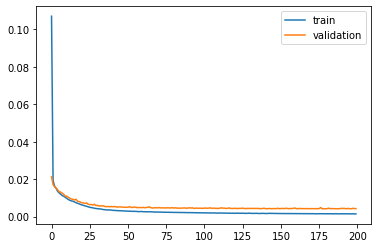

In [ ]:
# pretrain

# split pretrain data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(pretrain_features, pretrain_labels, test_size=0.2, random_state=1)

# fit the autoencoder+predictor model
history = net_pretrain.fit(X_train, [y_train, X_train], epochs=200, batch_size=120, verbose=2, workers=4, validation_data=(X_test, [y_test, X_test]))

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

encoder = Model(input, encoded)
encoder.save('drive/My Drive/My Colab/IML_task4/encoder.h5')

In [ ]:
# split train data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.1, random_state=1)

# load encoder
encoder = load_model('drive/My Drive/My Colab/IML_task4/encoder.h5', compile=False)

# encode features
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)

Epoch 1/400
30/30 - 3s - loss: 25.4473 - val_loss: 22.6255 - 3s/epoch - 90ms/step
Epoch 2/400
30/30 - 0s - loss: 21.9390 - val_loss: 19.5636 - 203ms/epoch - 7ms/step
Epoch 3/400
30/30 - 0s - loss: 19.0982 - val_loss: 16.7666 - 312ms/epoch - 10ms/step
Epoch 4/400
30/30 - 0s - loss: 16.7009 - val_loss: 14.0849 - 267ms/epoch - 9ms/step
Epoch 5/400
30/30 - 0s - loss: 14.6812 - val_loss: 12.1714 - 293ms/epoch - 10ms/step
Epoch 6/400
30/30 - 0s - loss: 12.9360 - val_loss: 13.9153 - 267ms/epoch - 9ms/step
Epoch 7/400
30/30 - 0s - loss: 11.5115 - val_loss: 12.1035 - 231ms/epoch - 8ms/step
Epoch 8/400
30/30 - 0s - loss: 10.2983 - val_loss: 12.3973 - 189ms/epoch - 6ms/step
Epoch 9/400
30/30 - 0s - loss: 9.2018 - val_loss: 10.8684 - 173ms/epoch - 6ms/step
Epoch 10/400
30/30 - 0s - loss: 8.2695 - val_loss: 10.5069 - 231ms/epoch - 8ms/step
Epoch 11/400
30/30 - 0s - loss: 7.4304 - val_loss: 23.9538 - 240ms/epoch - 8ms/step
Epoch 12/400
30/30 - 0s - loss: 6.7572 - val_loss: 75.8400 - 176ms/epoch - 6m

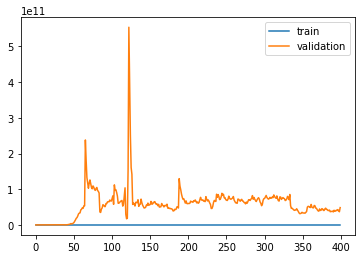

In [ ]:
# load the predictor
predictor = load_model('drive/My Drive/My Colab/IML_task4/predictor.h5', compile=True)
predictor.compile(optimizer='adam', loss='mse')

# fit the model for prediting homo-lumo gap
history_gap = predictor.fit(X_train_encoded, y_train, epochs=400, batch_size=3, verbose=2, workers=4, validation_data=(X_val_encoded, y_val))

# plot loss
plt.plot(history_gap.history['loss'], label='train')
plt.plot(history_gap.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Define model for training

input = Input(shape=(bottleneck,))
encoded = Dense(32, kernel_initializer='he_uniform', activation='relu')(input)
encoded = Dense(32, kernel_initializer='he_uniform', activation='relu')(encoded)
encoded = Dense(16, kernel_initializer='he_uniform', activation='relu')(encoded)
encoded = Dense(10, kernel_initializer='he_uniform', activation='relu')(encoded)
predicted = Dense(1, kernel_initializer='he_uniform', activation='linear')(encoded)
model = Model(input, predicted)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Epoch 1/400
23/23 - 0s - loss: 2.0073 - 389ms/epoch - 17ms/step
Epoch 2/400
23/23 - 0s - loss: 0.1495 - 50ms/epoch - 2ms/step
Epoch 3/400
23/23 - 0s - loss: 0.1037 - 58ms/epoch - 3ms/step
Epoch 4/400
23/23 - 0s - loss: 0.0882 - 48ms/epoch - 2ms/step
Epoch 5/400
23/23 - 0s - loss: 0.0756 - 49ms/epoch - 2ms/step
Epoch 6/400
23/23 - 0s - loss: 0.0678 - 49ms/epoch - 2ms/step
Epoch 7/400
23/23 - 0s - loss: 0.0612 - 48ms/epoch - 2ms/step
Epoch 8/400
23/23 - 0s - loss: 0.0615 - 49ms/epoch - 2ms/step
Epoch 9/400
23/23 - 0s - loss: 0.0556 - 55ms/epoch - 2ms/step
Epoch 10/400
23/23 - 0s - loss: 0.0503 - 45ms/epoch - 2ms/step
Epoch 11/400
23/23 - 0s - loss: 0.0503 - 48ms/epoch - 2ms/step
Epoch 12/400
23/23 - 0s - loss: 0.0480 - 45ms/epoch - 2ms/step
Epoch 13/400
23/23 - 0s - loss: 0.0456 - 68ms/epoch - 3ms/step
Epoch 14/400
23/23 - 0s - loss: 0.0460 - 45ms/epoch - 2ms/step
Epoch 15/400
23/23 - 0s - loss: 0.0420 - 47ms/epoch - 2ms/step
Epoch 16/400
23/23 - 0s - loss: 0.0403 - 46ms/epoch - 2ms/step

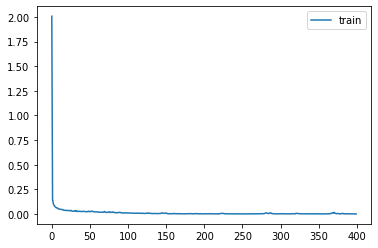

In [ ]:
# fit the model for prediting homo-lumo gap
history_gap = model.fit(X_train_encoded, y_train, epochs=400, batch_size=4, verbose=2, workers=4)

# plot loss
plt.plot(history_gap.history['loss'], label='train')
#plt.plot(history_gap.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
y_val_pred = model.predict(X_val_encoded)
score = mean_squared_error(y_val, y_val_pred, squared=False)
print('The RMSE score on validation set is:', score)

The RMSE score on validation set is: 0.17031375102193586


In [ ]:
# predict
test_features_encoded = encoder.predict(test_features)
test_labels = model.predict(test_features_encoded)
test_labels = test_labels.reshape((len(test_labels), 1))

num_test = len(test_labels)
test_features_ori = np.array(test_features_ori)
id = test_features_ori[:, 0]
id = id.reshape((num_test, 1))

out = np.hstack((id, test_labels))

data_df = pd.DataFrame(out, columns=['Id', 'y'])
data_df.to_csv('drive/My Drive/My Colab/IML_task4/submission.csv', index=None)